In [1]:
import numpy as np 
import pandas as pd
import os
import math
import random
import cv2
from time import time

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as Data
import wandb

import ColorLog as debug

from load_data import labelFpsDataLoader, labelTestDataLoader

In [2]:
wandb.init(project='plateRecog_crnn', entity='leleleooonnn')
config = wandb.config

# DEVICE = "cuda"
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']
chars = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", 
         "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", 'A', 
         'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
         'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

NUM_PROV = len(provinces)
NUM_ALPB = len(alphabets)
NUM_ADS = len(ads)
NUM_CHAR = len(chars)


PLATESIZE = (100,32)

TRAINDIR = ['CCPD2019/train']
TESTDIR = ['CCPD2019/test']
VALDIR = ['CCPD2019/val']
VALTXT = "CCPD2019/splits/val.txt"
TRAINTXT = "CCPD2019/splits/train.txt"
TESTTXT = "CCPD2019/splits/test.txt"

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: leleleooonnn (use `wandb login --relogin` to force relogin)
/media/largeHDD/yile/.conda/envs/tradt/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [5]:
# data loading 
# image size 720x1160x3 


image_types = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")

def persp_crop(img, corners, height, width):
    dst_points = np.array([(width, height), (0, height), (0, 0), (width, 0)], np.float32)
    transform_matrix = cv2.getPerspectiveTransform(corners, dst_points)
    dst = cv2.warpPerspective(img, transform_matrix, (width, height),flags=cv2.INTER_CUBIC)
#     dst = cv2.cvtColor(dst, cv2.COLOR_BGR2YUV)
#     dst[:,:,0] = cv2.equalizeHist(dst[:,:,0])
#     dst = cv2.cvtColor(dst, cv2.COLOR_YUV2BGR)
    return dst

def decode(preds):
    char_list = []
    code_list = []
    for i in range(len(preds)):
        if preds[i] != NUM_CHAR-1 and (not (i>0 and preds[i] == preds[i-1])):
            char_list.append(chars[preds[i]])
            code_list.append(preds[i])
    return code_list, char_list
    
def label_trans(label_list):
    assert len(label_list)==7
    out = [0]*7
    for ii, el in enumerate(label_list):
        if ii==0:
            out[ii] = int(el)
            if out[ii] == NUM_PROV-1:
                out[ii] = NUM_CHAR-1
        elif ii ==1:
            out[ii] = int(el)+NUM_PROV-1
            if out[ii] == NUM_ALPB-1:
                out[ii] = NUM_CHAR-1
        else:
            out[ii] = int(el)+NUM_PROV-1
            if out[ii] == NUM_ADS-1:
                out[ii] = NUM_CHAR-1
    return out


def list_images(basePath, contains=None):
    # return the set of files that are valid
    print(debug.INFO+"Loading data under %s"%basePath)
    return list_files(basePath, validExts=image_types, contains=contains)


def list_files(basePath, validExts=None, contains=None):
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if validExts is None or ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename)
                yield imagePath
                
class labelFpsDataLoader(Data.Dataset):
    def __init__(self, img_dir, imgSize, is_transform=None):
        self.img_dir = img_dir
        self.img_paths = []
        for i in range(len(img_dir)):
            self.img_paths += [el for el in list_images(img_dir[i])]
        # self.img_paths = os.listdir(img_dir)
        # print self.img_paths
        self.img_size = imgSize
        self.is_transform = is_transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_name = self.img_paths[index]
        img = cv2.imread(img_name)
#         plt.imshow(img[:,:,::-1])
#         plt.show()
        # img = img.astype('float32')
        lbl = img_name.split('/')[-1].rsplit('.', 1)[0].split('-')[-3]

        iname = img_name.rsplit('/', 1)[-1].rsplit('.', 1)[0].split('-')
        # fps = [[int(eel) for eel in el.split('&')] for el in iname[3].split('_')]
        # leftUp, rightDown = [min([fps[el][0] for el in range(4)]), min([fps[el][1] for el in range(4)])], [
        #     max([fps[el][0] for el in range(4)]), max([fps[el][1] for el in range(4)])]
        
#         print(debug.DEBUG,iname)
        
        [leftUp, rightDown] = [[int(eel) for eel in el.split('&')] for el in iname[2].split('_')]
        ori_w, ori_h = [float(int(el)) for el in [img.shape[1], img.shape[0]]]
        new_labels = [(leftUp[0] + rightDown[0]) / (2 * ori_w), (leftUp[1] + rightDown[1]) / (2 * ori_h),
                      (rightDown[0] - leftUp[0]) / ori_w, (rightDown[1] - leftUp[1]) / ori_h]
        croppedImage = img[leftUp[1]:rightDown[1],leftUp[0]:rightDown[0]]
        resizedImage = cv2.resize(croppedImage, self.img_size)
#         cv2.imshow('plate',resizedImage)
#         cv2.waitKey(0)
#         print(resizedImage.shape)
        resizedImage = np.transpose(resizedImage, (2,0,1))
        resizedImage = resizedImage.astype('float32')
        resizedImage /= 255.0
#         plt.imshow(np.transpose(resizedImage, (1,2,0)))
#         plt.show()
        
#         cv2.imshow('plate',np.transpose(resizedImage, (1,2,0)))
#         cv2.waitKey(0)
        
        return resizedImage, new_labels, lbl, img_name, iname
             
class labelFpsPathDataLoader(Data.Dataset):
    def __init__(self, pathtxt, baseDir, imgSize, is_transform=None):
#         self.img_dir = img_dir
#         self.img_paths = []
#         for i in range(len(img_dir)):
#             self.img_paths += [el for el in list_images(img_dir[i])]
        # self.img_paths = os.listdir(img_dir)
        # print self.img_paths
        print(debug.INFO+"Loading data under %s"%pathtxt)
        f = open(pathtxt)
        self.img_paths = [os.path.join(baseDir, line.rstrip('\n')) for line in f.readlines()]
        f.close()
#         print("init")
#         print(self.img_paths)
        
        self.img_size = imgSize
        self.is_transform = is_transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_name = self.img_paths[index]
#         img = cv2.imread(img_name)
        img = cv2.imread(img_name,cv2.IMREAD_GRAYSCALE)
#         img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        # img = img.astype('float32')
        lbl = img_name.split('/')[-1].rsplit('.', 1)[0].split('-')[-3]
#         old_lbl = lbl.split('_')[:7]
#         print("lbl",len(old_lbl))
#         new_lbl = label_trans(lbl.split('_')[:7])
#         print([chars[x] for x in new_lbl])
        iname = img_name.rsplit('/', 1)[-1].rsplit('.', 1)[0].split('-')
        
#         plt.imshow(img[:,:,::-1])
#         plt.imshow(img)
#         plt.show()
#         input()
        # fps = [[int(eel) for eel in el.split('&')] for el in iname[3].split('_')]
        # leftUp, rightDown = [min([fps[el][0] for el in range(4)]), min([fps[el][1] for el in range(4)])], [
        #     max([fps[el][0] for el in range(4)]), max([fps[el][1] for el in range(4)])]
        
#         print(debug.DEBUG,iname)
        
        [leftUp, rightDown] = [[int(eel) for eel in el.split('&')] for el in iname[2].split('_')]
        ori_w, ori_h = [float(int(el)) for el in [img.shape[1], img.shape[0]]]
        new_labels = [(leftUp[0] + rightDown[0]) / (2 * ori_w), (leftUp[1] + rightDown[1]) / (2 * ori_h),
                      (rightDown[0] - leftUp[0]) / ori_w, (rightDown[1] - leftUp[1]) / ori_h]
#         print(img.shape)
        croppedImage = img[leftUp[1]:rightDown[1],leftUp[0]:rightDown[0]]
#         print(croppedImage.shape)
        resizedImage = cv2.resize(croppedImage, self.img_size)
        resizedImage = np.expand_dims(resizedImage,0)
#         cv2.imshow('plate',resizedImage)
#         cv2.waitKey(0)
#         print(resizedImage.shape)
#         resizedImage = np.transpose(resizedImage, (2,0,1))
        resizedImage = resizedImage.astype('float32')
        resizedImage /= 255.0
#         plt.imshow(np.transpose(resizedImage, (1,2,0)))
#         plt.show()
        
#         cv2.imshow('plate',np.transpose(resizedImage, (1,2,0)))
#         cv2.waitKey(0)
        
        return resizedImage, new_labels, lbl, img_name, iname
      
class labelLoader(Data.Dataset):
    def __init__(self, img_dir, imgSize, is_transform=None):
        self.img_dir = img_dir
        self.img_paths = []
        for i in range(len(img_dir)):
            self.img_paths += [el for el in list_images(img_dir[i])]
        # self.img_paths = os.listdir(img_dir)
        # print self.img_paths
        self.img_size = imgSize
        self.is_transform = is_transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_name = self.img_paths[index]
#         img = cv2.imread(img_name)
#         # img = img.astype('float32')
#         resizedImage = cv2.resize(img, self.img_size)
#         resizedImage = np.transpose(resizedImage, (2,0,1))
#         resizedImage = resizedImage.astype('float32')
#         resizedImage /= 255.0
        lbl = img_name.split('/')[-1].rsplit('.', 1)[0].split('-')[-3]

        iname = img_name.rsplit('/', 1)[-1].rsplit('.', 1)[0].split('-')
        # fps = [[int(eel) for eel in el.split('&')] for el in iname[3].split('_')]
        # leftUp, rightDown = [min([fps[el][0] for el in range(4)]), min([fps[el][1] for el in range(4)])], [
        #     max([fps[el][0] for el in range(4)]), max([fps[el][1] for el in range(4)])]
        
#         print(debug.DEBUG,iname)
        
        [leftUp, rightDown] = [[int(eel) for eel in el.split('&')] for el in iname[2].split('_')]
#         ori_w, ori_h = [float(int(el)) for el in [img.shape[1], img.shape[0]]]
#         new_labels = [(leftUp[0] + rightDown[0]) / (2 * ori_w), (leftUp[1] + rightDown[1]) / (2 * ori_h),
#                       (rightDown[0] - leftUp[0]) / ori_w, (rightDown[1] - leftUp[1]) / ori_h]

        return lbl, img_name, iname



[INFO] -- Start loading dataset...
[INFO] -- Loading data under CCPD2019/splits/val.txt
init
[INFO] -- finish loading
99996
(1160, 720)
(79, 252)
(1, 64, 192)
(1160, 720)
(67, 288)
(1, 64, 192)
i
(1, 64, 192)


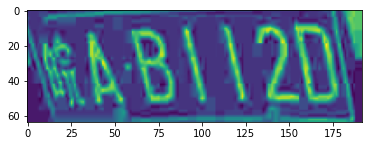

(1, 64, 192)


In [38]:
path = "CCPD2019/ccpd_base"
imgsize = (480,480)
platesize = (256,96)
# print(debug.INFO+"start loading data...")
# dst = labelFpsDataLoader([path],platesize)

print(debug.INFO+"Start loading dataset...")
# dst = labelFpsDataLoader(TRAINDIR, (256,96))

dst = labelFpsPathDataLoader("CCPD2019/splits/val.txt","CCPD2019", (192,64))
# print(debug.INFO+"Got dataset size %d"%len(dst))
# trainloader = Data.DataLoader(dst, batch_size=BATCHSIZE, shuffle=True, num_workers=8)

# dst = labelLoader([path],imgsize)
print(debug.INFO+"finish loading")
print(len(dst))
# sizes = []
# for _,_,iname in dst:
#     [leftUp, rightDown] = [[int(eel) for eel in el.split('&')] 
#                        for el in iname[2].split('_')]
#     sizes.append([leftUp[0]-rightDown[0],leftUp[1]-rightDown[1]])

# mean, std = np.mean(sizes, axis=0),np.std(sizes, axis=0)
# print(mean,std)
#     [-252.62252245  -94.97832957] [61.46956803 27.42365916]
img,_,_,_,iname = dst[random.randint(0,100)]


for img,_,_,_,iname in dst:
    print("i")
    print(img.shape)
#     img =np.transpose(img*255, (1,2,0)).astype("int")
#     img = img[:,:,::-1]
    plt.imshow(img[0])
    plt.show()
#     print(img)
    print(img.shape)
#     cv2.imshow('plate',img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    break


In [ ]:
class DigitRecog(nn.Module): 
    def __init__(self, imgSize):

        super(DigitRecog, self).__init__()
        self.name = "DigitRecog"
        
        self.stack1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(0.2)
        )
        self.stack2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(0.2)
        )
        self.stack3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(0.2)
        )
        self.stack4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(0.2)
        )
        self.stack5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(0.2)
        )
        self.activations = nn.Sequential(
            self.stack1,
            self.stack2,
            self.stack3,
            self.stack4,
            self.stack5
        )
        self.Length = int((imgSize[0]/(2**5))*(imgSize[1]/(2**5)))*512
        interft = 4096
        self.classifier1 = nn.Sequential(
            nn.Linear(self.Length, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, NUM_PROV)
        )
        self.classifier2 = nn.Sequential(
            nn.Linear(self.Length, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, NUM_ALPB)
        )
        
        self.classifier3 = nn.Sequential(
            nn.Linear(self.Length, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, NUM_ADS)
        )
        self.classifier4 = nn.Sequential(
            nn.Linear(self.Length, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, NUM_ADS)
        )
        self.classifier5 = nn.Sequential(
            nn.Linear(self.Length, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, NUM_ADS)
        )
        self.classifier6 = nn.Sequential(
            nn.Linear(self.Length, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, NUM_ADS)
        )
        self.classifier7 = nn.Sequential(
            nn.Linear(self.Length, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, interft),
            nn.ReLU(inplace=True),
            nn.Linear(interft, NUM_ADS)
        )
    def forward(self, x):
#         x = self.activations(x)
#         print(x.shape)
        x = self.stack1(x)
#         print(x.shape)
        x = self.stack2(x)
#         print(x.shape)
        x = self.stack3(x)
#         print(x.shape)
        x = self.stack4(x)
#         print(x.shape)
        x = self.stack5(x)
#         print(x.shape)
        
        x = x.view(x.size(0),-1)
#         print(self.Length, x.shape)
        prov = self.classifier1(x)
        alpb = self.classifier2(x)
        ads1 = self.classifier3(x)
        ads2 = self.classifier4(x)
        ads3 = self.classifier5(x)
        ads4 = self.classifier6(x)
        ads5 = self.classifier7(x)
        return prov,alpb,ads1,ads2,ads3,ads4,ads5   

    
# class DigitRecog(nn.Module): 
#     def __init__(self, imgSize):

#         super(DigitRecog, self).__init__()
#         self.name = "DigitRecog"
        
#         self.stack1 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(num_features=64),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(num_features=64),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
#             nn.Dropout(0.2)
#         )

In [4]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output


class CRNN(nn.Module):

    def __init__(self, imgH, nc, nclass, nh, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16

        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh),
            BidirectionalLSTM(nh, nh, nclass))

    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]

        # rnn features
        output = self.rnn(conv)

        return output

In [5]:

def eval(model, test_tar):
    use_gpu = True
    count, error, correct = 0, 0, 0
    dst = labelFpsPathDataLoader(test_tar,"CCPD2019", PLATESIZE)
#     dst = labelFpsDataLoader(test_tar, PLATESIZE)
    bsz = 16
    testloader = Data.DataLoader(dst, batch_size=bsz, shuffle=True, num_workers=8)
    start = time()
#     corrs_eachchar = np.zeros((7))
    corrs_eachinst =[]
    for i, (XI,_, labels, ims, _) in enumerate(testloader):
        
        corr_eachinst =[]
#         assert len(labels) == bsz
        count += len(labels)
#         YI = [[int(ee) for ee in el.split('_')[:7]] for el in labels]
#         labelGT = np.array([[int(ee) for ee in el.split('_')[:7]] for el in labels])
        YI = np.array([label_trans(el.split('_')[:7]) for el in labels])
        if use_gpu:
            x = Variable(XI.cuda(0))
            lbl = Variable(torch.LongTensor(YI).cuda())
        else:
            x = Variable(XI)
            lbl = Variable(torch.LongTensor(YI))
        # Forward pass: Compute predicted y by passing x to the model

        y_pred = model(x)
#         print(y_pred.shape)
#         input()
#         outputY = [el.data.cpu().numpy().tolist() for el in y_pred]
#         labelPred = [t[0].index(max(t[0])) for each in btch for btch in outputY]
        
        _, preds = y_pred.max(2)
        preds = preds.transpose(1, 0).contiguous()
        for i in range(lbl.shape[0]):
            n_correct = 0
            sim_preds, _ = decode(preds[i].data)
#             print(sim_preds,lbl[i].data)
            for pred, target in zip(sim_preds, lbl[i].data):
                if pred == target:
                    n_correct += 1
            corr_eachinst.append(n_correct)
            

#         labelPred = np.array([np.argmax(branch, axis=1) for branch in outputY])
#         print(labelPred)
#         scoreboard = (labelPred.T == labelGT)
#         corr_eachinst = np.sum(scoreboard, axis=1)
#         corr_eachchar = np.sum(scoreboard, axis=0)
#         print(corr_eachinst,len(corr_eachinst))
#         assert len(corr_eachinst) == bsz
#         assert len(corr_eachchar) == 7
        corrs_eachinst = np.append(corrs_eachinst,corr_eachinst)
#         corrs_eachchar = corrs_eachchar+corr_eachchar
        
#         tmp = corr_eachchar/len(labels)
#         table = wandb.Table(data=list(corr_eachchar/len(labels)),columns=['1','2','3','4','5','6','7'])
        
        
        if i%10 ==1:
            print(debug.INFO+"image: {}, inst:{}".format(count,np.mean(corrs_eachinst)))#, corrs_eachchar/count))
#         def isEqual(labelGT, labelP):
#             compare = [1 if int(labelGT[i]) == int(labelP[i]) else 0 for i in range(7)]
#             # print(sum(compare))
#             return sum(compare)

#         #   compare YI, outputY
#         try:
#             if isEqual(labelPred, YI[0]) == 7:
#                 correct += 1
#             else:
#                 pass
#         except:
#             print(debug.WARN+"val fails")
#             error += 1
# correct, error, float(correct) / count,
    wandb.log({'val':{
        'image#':count,
        'corr_in_instance':np.mean(corrs_eachinst),
        'accu_instance':np.mean(corrs_eachinst)/7,
        'accu_all_corr':len(corrs_eachinst[corrs_eachinst==7]),
        'corr_distrb':wandb.Histogram(corrs_eachinst),
        'corr_inst':corrs_eachinst
              }})  
    
    return count, corrs_eachinst, np.mean(corrs_eachinst)/7, (time()-start) / count


def train_model(model, trainloader, criterion, optimizer,batchSize, testDirs,storeName, num_epochs=25, logFile="./train_log.txt"):
    # since = time.time()
    use_gpu = True
    lrScheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
    cnt = 0

    
    for epoch in range(num_epochs):
        lossAver = []
        model.train(True)
        lrScheduler.step()
        start = time()
        print(debug.INFO+"Epoch {} started at {}".format(epoch,start))

        for i, (XI, _, labels, _, _) in enumerate(trainloader):
            cnt +=1
            if not len(XI) == batchSize:
                
                continue
                        
            YI = [label_trans(el.split('_')[:7]) for el in labels]
#             Y = np.array([el.numpy() for el in Y]).T
            if use_gpu:
                x = Variable(XI.cuda())
                lbl = Variable(torch.LongTensor(YI).cuda())
#                 y = Variable(torch.FloatTensor(Y).cuda(), requires_grad=False)
            else:
                x = Variable(XI)
                lbl = Variable(torch.LongTensor(YI))
    
#             print(debug.INFO+"input shape {}".format(x.shape))
            y_pred = model(x)
#             print(debug.INFO+"output size:",y_pred.shape)
#             print(debug.INFO+"output shape {}".format([yy.shape for yy in y_pred]))
#             try:
#                 y_pred = model(x)
#                 print(debug.INFO+"output shape {}".format(y_pred.shape))
                
#             except:
#                 print(debug.WARN+"iter %d model prediction fails"%i)
#                 continue
                
            # Compute and print loss
#             loss = 0.0
#             train_correct = []
#             loss += 0.8 * nn.L1Loss().cuda()(fps_pred[:][:2], y[:][:2])
#             loss += 0.2 * nn.L1Loss().cuda()(fps_pred[:][2:], y[:][2:])
            y_pred = F.log_softmax(y_pred,dim=2)
            preds_size = Variable(torch.IntTensor([y_pred.size(0)] * batchSize))
            tars_size = Variable(torch.IntTensor([7] * batchSize))
#             print("loss input",y_pred,lbl,preds_size,tars_size)
            loss  = criterion(y_pred,lbl,preds_size,tars_size)
#             for j in range(7):
#                 l = lbl[:,j]
#                 loss += criterion(y_pred[j], l)
#                 train_correct.append(np.argmax(y_pred[j],axis=1))
#                 acc = len(train_correct[train_correct==0])/len(train_correct)

#             def isEqual(labelGT, labelP):
#                 compare = [1 if int(labelGT[i]) == int(labelP[i]) else 0 for i in range(7)]
#                 # print(sum(compare))
#                 return sum(compare)
            
#             for ii in range(batchSize):
#                 if isEqual(labelPred, YI[ii]) == 7:
#                     correct += 1


                    
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
#             print(loss)
            lossAver.append(loss.item())

#             try:
#                 print(loss)
#                 lossAver.append(loss.data[0])
#             except:
#                 print(debug.ERR+"iter %d lossAver append error"%i)
            if cnt % 100 == 0:
                wandb.log({'train':{
                    'cur_loss':loss,
                    'ave_loss':np.mean(lossAver)
                          }})  
            
            if i % 50 == 1:
                print('trained %s images, use %s seconds, loss %s\n' % (i*batchSize, time() - start, sum(lossAver) / len(lossAver) if len(lossAver)>0 else 'NoLoss'))
                with open(logFile, 'a') as outF:
                    outF.write('trained %s images, use %s seconds, loss %s\n' % (i*batchSize, time() - start, sum(lossAver) / len(lossAver) if len(lossAver)>0 else 'NoLoss'))
                torch.save(model.state_dict(), storeName)
        print ('*************Epoch %s Avrg Training loss %s Elapsed %s\n' % (epoch, sum(lossAver) / len(lossAver), time()-start))
        
        model.eval()
        count, correct, precision, avgTime = eval(model, testDirs)
        with open(logFile, 'a') as outF:
            outF.write('Epoch %s Avrg Training loss %s Elapsed %s\n' % (epoch, sum(lossAver) / len(lossAver), time() - start))
            outF.write('************* Validation: total %s precision %s avgTime %s\n' % (count, precision, avgTime))
        torch.save(model.state_dict(), storeName + str(epoch))
        print('************* Validation: total %s precision %s avgTime %s\n' % (count, precision, avgTime))
    return model


In [6]:
# training 
torch.cuda.set_device(0)
torch.cuda.empty_cache()

TRAINDIR = ['CCPD2019/train']
TESTDIR = ['CCPD2019/test']
VALDIR = ['CCPD2019/val']

LR = 0.001
PLATESIZE = (100,32)#(256,96)
BATCHSIZE = 16
EPOCH = 300


# model = DigitRecog(PLATESIZE).cuda()
model = CRNN(imgH=32, nc=1, nclass=NUM_CHAR, nh=256, n_rnn=2, leakyRelu=False).cuda()
# criterion = nn.CrossEntropyLoss()
criterion = nn.CTCLoss(blank=NUM_CHAR-1,reduction='mean').cuda()
optimizer = optim.Adam(model.parameters(),lr=LR)
# lrScheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# optimizer_conv = optim.RMSprop(model_conv.parameters(), lr=0.01, momentum=0.9)
# optimizer_conv = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
print(debug.INFO+"Start loading dataset...")
# dst = labelFpsDataLoader(TRAINDIR, PLATESIZE)
dst = labelFpsPathDataLoader(TRAINTXT,"CCPD2019", PLATESIZE)
print(debug.INFO+"Got dataset size %d"%len(dst))
trainloader = Data.DataLoader(dst, batch_size=BATCHSIZE, shuffle=True, num_workers=8)
print(debug.INFO+"Done loading dataset")

print(debug.INFO+"Start training")
model = train_model(model=model, trainloader=trainloader, criterion=criterion, optimizer=optimizer,
            batchSize=BATCHSIZE, testDirs=VALTXT,storeName='./weight/crnn.pth', num_epochs=EPOCH, logFile="./train_log.txt")

[INFO] -- Start loading dataset...
[INFO] -- Loading data under CCPD2019/splits/train.txt
[INFO] -- Got dataset size 100000
[INFO] -- Done loading dataset
[INFO] -- Start training
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
[INFO] -- Epoch 0 started at 1619458112.2549222


/media/largeHDD/yile/.conda/envs/tradt/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


trained 16 images, use 2.1929969787597656 seconds, loss 12.21277904510498

trained 816 images, use 7.8445422649383545 seconds, loss 3.7211217146653395

trained 1616 images, use 13.907752752304077 seconds, loss 3.2029084013957605

trained 2416 images, use 18.95317530632019 seconds, loss 2.983241740025972

trained 3216 images, use 24.33391046524048 seconds, loss 2.875131326146645

trained 4016 images, use 28.79421877861023 seconds, loss 2.8042495004714483

trained 4816 images, use 33.81403207778931 seconds, loss 2.75149752762144

trained 5616 images, use 38.37854886054993 seconds, loss 2.7146155217831787

trained 6416 images, use 42.83934426307678 seconds, loss 2.684877956091468

trained 7216 images, use 47.912712812423706 seconds, loss 2.6620673711320997

trained 8016 images, use 52.5118887424469 seconds, loss 2.644578522894962

trained 8816 images, use 57.33748412132263 seconds, loss 2.625894702863002

trained 9616 images, use 62.09454035758972 seconds, loss 2.6084792899134945

trained

trained 84016 images, use 490.908686876297 seconds, loss 0.6609762347515592

trained 84816 images, use 495.46973609924316 seconds, loss 0.6549752895000645

trained 85616 images, use 499.7852499485016 seconds, loss 0.6492358161752866

trained 86416 images, use 505.0869801044464 seconds, loss 0.6433656252393936

trained 87216 images, use 509.65105676651 seconds, loss 0.6377209586229535

trained 88016 images, use 515.0532627105713 seconds, loss 0.6323557689658835

trained 88816 images, use 519.5434823036194 seconds, loss 0.6268271957213791

trained 89616 images, use 524.5155968666077 seconds, loss 0.6213584189310783

trained 90416 images, use 529.0786483287811 seconds, loss 0.6160475593034509

trained 91216 images, use 534.3454384803772 seconds, loss 0.6109456057499685

trained 92016 images, use 539.0115280151367 seconds, loss 0.6057386638922544

trained 92816 images, use 543.7485902309418 seconds, loss 0.6005762374658073

trained 93616 images, use 548.4094924926758 seconds, loss 0.595666

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


[INFO] -- image: 99996, inst:6.704178167126685
************* Validation: total 99996 precision 0.9577397381609549 avgTime 0.006347344245351387

Adjusting learning rate of group 0 to 1.0000e-03.
[INFO] -- Epoch 1 started at 1619459332.0251627
trained 16 images, use 1.073909044265747 seconds, loss -0.0019346005283296108

trained 816 images, use 5.477415084838867 seconds, loss 0.000399648514128505

trained 1616 images, use 9.984659194946289 seconds, loss 0.01678889948651012

trained 2416 images, use 13.98099660873413 seconds, loss 0.013508893392434785

trained 3216 images, use 18.482407569885254 seconds, loss 0.016115454363862587

trained 4016 images, use 22.99678921699524 seconds, loss 0.018936905673139597

trained 4816 images, use 27.63501811027527 seconds, loss 0.019126069002294455

trained 5616 images, use 31.74067497253418 seconds, loss 0.019420424384654987

trained 6416 images, use 36.22854399681091 seconds, loss 0.019977382193979765

trained 7216 images, use 41.15202355384827 secon

trained 79216 images, use 452.65717816352844 seconds, loss 0.01126582238193423

trained 80016 images, use 458.1374430656433 seconds, loss 0.011119532165199392

trained 80816 images, use 462.90202498435974 seconds, loss 0.011092643080276373

trained 81616 images, use 467.7132661342621 seconds, loss 0.010962817875666307

trained 82416 images, use 472.5462131500244 seconds, loss 0.010941379473224967

trained 83216 images, use 477.08877897262573 seconds, loss 0.010824507945956146

trained 84016 images, use 481.6532349586487 seconds, loss 0.01078372724105211

trained 84816 images, use 486.49200320243835 seconds, loss 0.010664408691694239

trained 85616 images, use 491.0672700405121 seconds, loss 0.010641382378945841

trained 86416 images, use 495.74180269241333 seconds, loss 0.01064342305246992

trained 87216 images, use 500.70397758483887 seconds, loss 0.010537388641912502

trained 88016 images, use 505.4090919494629 seconds, loss 0.0105216774530658

trained 88816 images, use 509.760244369

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


[INFO] -- image: 99996, inst:6.7454998199928
************* Validation: total 99996 precision 0.9636428314275428 avgTime 0.005930569220640225

Adjusting learning rate of group 0 to 1.0000e-03.
[INFO] -- Epoch 2 started at 1619460499.848509
trained 16 images, use 2.7084755897521973 seconds, loss -0.036870991345494986

trained 816 images, use 7.3764519691467285 seconds, loss -0.0013377551244607626

trained 1616 images, use 11.876415252685547 seconds, loss -0.003569581594966425

trained 2416 images, use 16.712117195129395 seconds, loss -0.005591683026547176

trained 3216 images, use 21.575770616531372 seconds, loss -0.0063172924850426505

trained 4016 images, use 26.091309309005737 seconds, loss -0.005256609908039016

trained 4816 images, use 30.655241012573242 seconds, loss -0.005760613715566004

trained 5616 images, use 35.42093086242676 seconds, loss -0.006582586302101845

trained 6416 images, use 40.34227681159973 seconds, loss -0.0061500439694294915

trained 7216 images, use 44.907372

trained 78416 images, use 461.7364227771759 seconds, loss -0.0039290914120817455

trained 79216 images, use 466.36350202560425 seconds, loss -0.004034996367532315

trained 80016 images, use 471.0814108848572 seconds, loss -0.004015988034817095

trained 80816 images, use 476.0512218475342 seconds, loss -0.00409890652480573

trained 81616 images, use 480.5691907405853 seconds, loss -0.004088105796812358

trained 82416 images, use 484.7925684452057 seconds, loss -0.004146674143824311

trained 83216 images, use 489.3310618400574 seconds, loss -0.004136301608740654

trained 84016 images, use 493.8360595703125 seconds, loss -0.004119815146317129

trained 84816 images, use 498.11960554122925 seconds, loss -0.004054905323499242

trained 85616 images, use 503.31123328208923 seconds, loss -0.00392676160418562

trained 86416 images, use 507.44636964797974 seconds, loss -0.003915182632029804

trained 87216 images, use 512.1558127403259 seconds, loss -0.0038412730987144035

trained 88016 images, us

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


************* Validation: total 99996 precision 0.9652257518872184 avgTime 0.006917778070108706

Adjusting learning rate of group 0 to 1.0000e-03.
[INFO] -- Epoch 3 started at 1619461779.4367404
trained 16 images, use 1.9163501262664795 seconds, loss 0.016377918422222137

trained 816 images, use 5.843927621841431 seconds, loss -0.014842554314572435

trained 1616 images, use 10.398487091064453 seconds, loss -0.006433104937861893

trained 2416 images, use 14.598962783813477 seconds, loss -0.005855453666491054

trained 3216 images, use 18.80381178855896 seconds, loss -0.006954480748823014

trained 4016 images, use 23.47851586341858 seconds, loss -0.009089763168525505

trained 4816 images, use 27.715797424316406 seconds, loss -0.009097869054064315

trained 5616 images, use 32.00524425506592 seconds, loss -0.010332687128042877

trained 6416 images, use 36.63849449157715 seconds, loss -0.008522613227004833

trained 7216 images, use 41.23138642311096 seconds, loss -0.007256147047335826

train

trained 79216 images, use 455.2528431415558 seconds, loss -0.008984202572262418

trained 80016 images, use 459.8563768863678 seconds, loss -0.009031492363028039

trained 80816 images, use 464.3423807621002 seconds, loss -0.009050569019762165

trained 81616 images, use 468.77282762527466 seconds, loss -0.009047968679582605

trained 82416 images, use 473.66902112960815 seconds, loss -0.009095870029499487

trained 83216 images, use 477.80554151535034 seconds, loss -0.009060910852777337

trained 84016 images, use 482.7035331726074 seconds, loss -0.009093714779291549

trained 84816 images, use 487.1995515823364 seconds, loss -0.009031880384175212

trained 85616 images, use 491.4808225631714 seconds, loss -0.009077649161105662

trained 86416 images, use 495.9306261539459 seconds, loss -0.00913551130929818

trained 87216 images, use 500.4843661785126 seconds, loss -0.009207565392386888

trained 88016 images, use 505.62132835388184 seconds, loss -0.009300832651195712

trained 88816 images, use

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


[INFO] -- image: 99996, inst:6.750860034401376
************* Validation: total 99996 precision 0.9644085763430538 avgTime 0.006886697620424043

Adjusting learning rate of group 0 to 1.0000e-04.
[INFO] -- Epoch 4 started at 1619463042.8540952
trained 16 images, use 1.487950325012207 seconds, loss -0.025088459253311157

trained 816 images, use 5.389862298965454 seconds, loss -0.007682480328255154

trained 1616 images, use 9.781745433807373 seconds, loss -0.008972178270079323

trained 2416 images, use 13.968791723251343 seconds, loss -0.011899214379426619

trained 3216 images, use 18.576775312423706 seconds, loss -0.01191217927875961

trained 4016 images, use 22.87687873840332 seconds, loss -0.013605834242399497

trained 4816 images, use 27.3362717628479 seconds, loss -0.013888735361102373

trained 5616 images, use 32.09095883369446 seconds, loss -0.01451723571529907

trained 6416 images, use 36.40510559082031 seconds, loss -0.015976713848205003

trained 7216 images, use 40.58477520942688

trained 78416 images, use 447.45142889022827 seconds, loss -0.021840595256715865

trained 79216 images, use 451.92606949806213 seconds, loss -0.021804684916544494

trained 80016 images, use 456.37587213516235 seconds, loss -0.021898936822205017

trained 80816 images, use 461.1751310825348 seconds, loss -0.022009336902333008

trained 81616 images, use 465.3911187648773 seconds, loss -0.021977004993073798

trained 82416 images, use 470.0797760486603 seconds, loss -0.021914340507605885

trained 83216 images, use 474.8238260746002 seconds, loss -0.021881757905229844

trained 84016 images, use 478.9770407676697 seconds, loss -0.021957299199430545

trained 84816 images, use 483.4370038509369 seconds, loss -0.02194684698527116

trained 85616 images, use 487.8607511520386 seconds, loss -0.021923680383064144

trained 86416 images, use 492.29532194137573 seconds, loss -0.021925825138434215

trained 87216 images, use 497.14581394195557 seconds, loss -0.0219492413884366

trained 88016 images, use 

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


[INFO] -- image: 99996, inst:6.780661226449058
************* Validation: total 99996 precision 0.9686658894927226 avgTime 0.006058560466236093

Adjusting learning rate of group 0 to 1.0000e-04.
[INFO] -- Epoch 5 started at 1619464217.4328358
trained 16 images, use 1.448988914489746 seconds, loss 7.494927558582276e-05

trained 816 images, use 5.703912019729614 seconds, loss -0.030348101728052895

trained 1616 images, use 10.138578176498413 seconds, loss -0.030219367428906158

trained 2416 images, use 14.395485401153564 seconds, loss -0.030120155704480567

trained 3216 images, use 18.371577739715576 seconds, loss -0.02812043658190359

trained 4016 images, use 22.8414204120636 seconds, loss -0.027891261206821668

trained 4816 images, use 26.90676712989807 seconds, loss -0.026793838663920815

trained 5616 images, use 31.54097318649292 seconds, loss -0.026682249478643495

trained 6416 images, use 35.5938880443573 seconds, loss -0.026805488853041702

trained 7216 images, use 40.1716291904449

trained 79216 images, use 441.8514549732208 seconds, loss -0.026301304580690903

trained 80016 images, use 446.9004502296448 seconds, loss -0.02632371524023296

trained 80816 images, use 450.95304012298584 seconds, loss -0.0262754865734109

trained 81616 images, use 455.7040910720825 seconds, loss -0.02628048040847728

trained 82416 images, use 460.0924127101898 seconds, loss -0.026274279305217498

trained 83216 images, use 464.6136567592621 seconds, loss -0.02631403282690691

trained 84016 images, use 469.4829180240631 seconds, loss -0.026277375942507647

trained 84816 images, use 473.9786767959595 seconds, loss -0.026287003786855032

trained 85616 images, use 478.8715341091156 seconds, loss -0.026327178605017133

trained 86416 images, use 483.67493987083435 seconds, loss -0.026313277240265366

trained 87216 images, use 488.28991436958313 seconds, loss -0.026315891469225847

trained 88016 images, use 493.9093623161316 seconds, loss -0.026232720511209985

trained 88816 images, use 499.

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


[INFO] -- image: 99996, inst:6.782291291651666
************* Validation: total 99996 precision 0.968898755950238 avgTime 0.006452718934200636

Adjusting learning rate of group 0 to 1.0000e-04.
[INFO] -- Epoch 6 started at 1619465438.9172044
trained 16 images, use 1.4971067905426025 seconds, loss -0.019314477685838938

trained 816 images, use 5.165174961090088 seconds, loss -0.031060357759892774

trained 1616 images, use 10.153250932693481 seconds, loss -0.02791648755529048

trained 2416 images, use 14.148023128509521 seconds, loss -0.028015987391319486

trained 3216 images, use 18.413860082626343 seconds, loss -0.027260983573724654

trained 4016 images, use 22.85670828819275 seconds, loss -0.026852893982005112

trained 4816 images, use 26.85520601272583 seconds, loss -0.02583975074588468

trained 5616 images, use 31.461803913116455 seconds, loss -0.025663435442089103

trained 6416 images, use 36.07581162452698 seconds, loss -0.026728221750927695

trained 7216 images, use 40.18474268913

trained 79216 images, use 450.9960563182831 seconds, loss -0.02756615652068635

trained 80016 images, use 455.94584679603577 seconds, loss -0.027575056001969193

trained 80816 images, use 460.1220672130585 seconds, loss -0.027493057496690974

trained 81616 images, use 464.7276952266693 seconds, loss -0.027603935225844447

trained 82416 images, use 469.4644901752472 seconds, loss -0.027623949040594162

trained 83216 images, use 474.3327555656433 seconds, loss -0.02760599741172181

trained 84016 images, use 478.8148863315582 seconds, loss -0.027589311989663017

trained 84816 images, use 483.4686806201935 seconds, loss -0.02758544314980372

trained 85616 images, use 487.94203186035156 seconds, loss -0.027602729217233432

trained 86416 images, use 492.60308361053467 seconds, loss -0.027543525305683794

trained 87216 images, use 497.08562183380127 seconds, loss -0.027557294347747455

trained 88016 images, use 501.70414996147156 seconds, loss -0.027634479864425066

trained 88816 images, use 

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


[INFO] -- image: 99996, inst:6.78388135525421
************* Validation: total 99996 precision 0.9691259078934585 avgTime 0.005712458439228835

Adjusting learning rate of group 0 to 1.0000e-04.
[INFO] -- Epoch 7 started at 1619466579.2896016
trained 16 images, use 1.4034509658813477 seconds, loss 0.0381492264168628

trained 816 images, use 4.995020151138306 seconds, loss -0.016411547787216617

trained 1616 images, use 9.602618932723999 seconds, loss -0.02007259507188471

trained 2416 images, use 13.955813884735107 seconds, loss -0.023438544985597935

trained 3216 images, use 17.86880850791931 seconds, loss -0.025538612994507888

trained 4016 images, use 22.17985200881958 seconds, loss -0.02637079578820819

trained 4816 images, use 26.451919078826904 seconds, loss -0.026058456867306914

trained 5616 images, use 30.729507207870483 seconds, loss -0.02631707584755945

trained 6416 images, use 35.43100190162659 seconds, loss -0.026346953260253398

trained 7216 images, use 39.72015023231506 s

trained 79216 images, use 447.6905539035797 seconds, loss -0.028193158401386177

trained 80016 images, use 452.5872790813446 seconds, loss -0.028196471142764596

trained 80816 images, use 457.25717067718506 seconds, loss -0.02825015061588679

trained 81616 images, use 462.330406665802 seconds, loss -0.02828659496291149

trained 82416 images, use 467.13938188552856 seconds, loss -0.028301661835506704

trained 83216 images, use 471.3018808364868 seconds, loss -0.02833035677392621

trained 84016 images, use 476.1698226928711 seconds, loss -0.028289853498819163

trained 84816 images, use 480.8119456768036 seconds, loss -0.028318973841051247

trained 85616 images, use 485.7782862186432 seconds, loss -0.028335001740257378

trained 86416 images, use 490.1796193122864 seconds, loss -0.02841062223812458

trained 87216 images, use 494.6741545200348 seconds, loss -0.028407036520810062

trained 88016 images, use 499.64514112472534 seconds, loss -0.028465633896290296

trained 88816 images, use 504.

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


[INFO] -- image: 99996, inst:6.784121364854594
************* Validation: total 99996 precision 0.9691601949792278 avgTime 0.005751434936681372

Adjusting learning rate of group 0 to 1.0000e-04.
[INFO] -- Epoch 8 started at 1619467725.3675642
trained 16 images, use 1.7027957439422607 seconds, loss -0.04741908982396126

trained 816 images, use 6.2812111377716064 seconds, loss -0.027078479569301914

trained 1616 images, use 10.838730096817017 seconds, loss -0.0270213466389542

trained 2416 images, use 15.930056095123291 seconds, loss -0.028752584866077468

trained 3216 images, use 20.473485708236694 seconds, loss -0.030078771738042652

trained 4016 images, use 25.290859699249268 seconds, loss -0.029715178079478783

trained 4816 images, use 30.075589656829834 seconds, loss -0.02914623474739438

trained 5616 images, use 34.50355911254883 seconds, loss -0.029365900850944048

trained 6416 images, use 39.34705376625061 seconds, loss -0.030317824831727826

trained 7216 images, use 43.7577755451

trained 78416 images, use 457.3935389518738 seconds, loss -0.028758460711836905

trained 79216 images, use 462.12729239463806 seconds, loss -0.02882499987581171

trained 80016 images, use 466.3116044998169 seconds, loss -0.02874935738549141

trained 80816 images, use 471.6494834423065 seconds, loss -0.028828304547116143

trained 81616 images, use 475.84455156326294 seconds, loss -0.028799890356714083

trained 82416 images, use 480.3361690044403 seconds, loss -0.028754479333112596

trained 83216 images, use 485.72611236572266 seconds, loss -0.028729027498945913

trained 84016 images, use 490.50288462638855 seconds, loss -0.028714070850743182

trained 84816 images, use 495.68327713012695 seconds, loss -0.028805290698821966

trained 85616 images, use 500.0829463005066 seconds, loss -0.02885421104597372

trained 86416 images, use 504.29361295700073 seconds, loss -0.028916440032726778

trained 87216 images, use 508.9952690601349 seconds, loss -0.028931307642251616

trained 88016 images, use

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


[INFO] -- image: 99996, inst:6.784711388455539
************* Validation: total 99996 precision 0.9692444840650769 avgTime 0.00568431228622207

Adjusting learning rate of group 0 to 1.0000e-05.
[INFO] -- Epoch 9 started at 1619468877.0225995
trained 16 images, use 1.554049015045166 seconds, loss -0.03673103079199791

trained 816 images, use 5.414200067520142 seconds, loss -0.02138492304304516

trained 1616 images, use 9.379917621612549 seconds, loss -0.02389721961332957

trained 2416 images, use 14.149176359176636 seconds, loss -0.02374847458923724

trained 3216 images, use 18.201938152313232 seconds, loss -0.026850432674222033

trained 4016 images, use 22.355018854141235 seconds, loss -0.027477372441469

trained 4816 images, use 26.638497352600098 seconds, loss -0.029249015054375792

trained 5616 images, use 30.729841709136963 seconds, loss -0.029477217137153646

trained 6416 images, use 35.11447286605835 seconds, loss -0.029762493768480204

trained 7216 images, use 39.58793306350708 s

trained 79216 images, use 457.948543548584 seconds, loss -0.03005501968851198

trained 80016 images, use 462.57398295402527 seconds, loss -0.03003372197898142

trained 80816 images, use 466.95521330833435 seconds, loss -0.030130473122745076

trained 81616 images, use 472.11706614494324 seconds, loss -0.030193657946600772

trained 82416 images, use 476.9968912601471 seconds, loss -0.03016478444213127

trained 83216 images, use 481.8847818374634 seconds, loss -0.030131853300581695

trained 84016 images, use 487.53297758102417 seconds, loss -0.030159734584310358

trained 84816 images, use 493.2306525707245 seconds, loss -0.030225864545521862

trained 85616 images, use 497.93556213378906 seconds, loss -0.030177030110027408

trained 86416 images, use 502.91178488731384 seconds, loss -0.030195205288540774

trained 87216 images, use 508.13645911216736 seconds, loss -0.0302128179494821

trained 88016 images, use 513.0223937034607 seconds, loss -0.030186656810910203

trained 88816 images, use 5

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


[INFO] -- image: 99996, inst:6.785751430057203
************* Validation: total 99996 precision 0.9693930614367432 avgTime 0.005675316662820626

Adjusting learning rate of group 0 to 1.0000e-05.
[INFO] -- Epoch 10 started at 1619470030.9116197
trained 16 images, use 1.42850661277771 seconds, loss 0.002043015672825277

trained 816 images, use 5.619229316711426 seconds, loss -0.023416033188718408

trained 1616 images, use 9.927239179611206 seconds, loss -0.02045066740945057

trained 2416 images, use 13.947385311126709 seconds, loss -0.024727204571191624

trained 3216 images, use 18.425333976745605 seconds, loss -0.02745562507133589

trained 4016 images, use 22.350926399230957 seconds, loss -0.027748589083799628

trained 4816 images, use 27.052729606628418 seconds, loss -0.02708184413342787

trained 5616 images, use 31.607714414596558 seconds, loss -0.028171777995347404

trained 6416 images, use 35.7643518447876 seconds, loss -0.028448682791008085

trained 7216 images, use 40.1636226177215

trained 79216 images, use 456.56595635414124 seconds, loss -0.0306600383473312

trained 80016 images, use 461.1497037410736 seconds, loss -0.030717600969966456

trained 80816 images, use 465.83617901802063 seconds, loss -0.030712565662607487

trained 81616 images, use 469.92242074012756 seconds, loss -0.030692162385298

trained 82416 images, use 474.4310894012451 seconds, loss -0.030712338089304122

trained 83216 images, use 479.41029024124146 seconds, loss -0.030680789718498094

trained 84016 images, use 483.84412908554077 seconds, loss -0.03064017180283233

trained 84816 images, use 488.70350313186646 seconds, loss -0.030558413121182612

trained 85616 images, use 493.34578251838684 seconds, loss -0.03061136076428904

trained 86416 images, use 498.1509208679199 seconds, loss -0.030612697709755065

trained 87216 images, use 502.19467639923096 seconds, loss -0.03051688973341874

trained 88016 images, use 507.2265102863312 seconds, loss -0.030545881989593585

trained 88816 images, use 51

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


[INFO] -- image: 99996, inst:6.785711428457138
************* Validation: total 99996 precision 0.9693873469224483 avgTime 0.005845809775384179

Adjusting learning rate of group 0 to 1.0000e-05.
[INFO] -- Epoch 11 started at 1619471193.3790886
trained 16 images, use 1.738347053527832 seconds, loss -0.09440413862466812

trained 816 images, use 5.9271955490112305 seconds, loss -0.03317800743286625

trained 1616 images, use 10.231775999069214 seconds, loss -0.028004726845683406

trained 2416 images, use 14.227192163467407 seconds, loss -0.02931858217830926

trained 3216 images, use 18.523646116256714 seconds, loss -0.029133525464660557

trained 4016 images, use 22.83735203742981 seconds, loss -0.030247372171633258

trained 4816 images, use 27.228439807891846 seconds, loss -0.03158150430408719

trained 5616 images, use 32.10975456237793 seconds, loss -0.032399138366167014

trained 6416 images, use 36.19157886505127 seconds, loss -0.03283802660465297

trained 7216 images, use 40.857794761657

trained 79216 images, use 458.4715220928192 seconds, loss -0.030942529181277757

trained 80016 images, use 463.2561376094818 seconds, loss -0.031029171635056446

trained 80816 images, use 467.65830993652344 seconds, loss -0.03098356134732497

trained 81616 images, use 472.30497670173645 seconds, loss -0.031022172507697485

trained 82416 images, use 477.29600620269775 seconds, loss -0.031028030379041158

trained 83216 images, use 482.08952021598816 seconds, loss -0.03098169153680299

trained 84016 images, use 486.57530069351196 seconds, loss -0.030979192952157796

trained 84816 images, use 491.4605851173401 seconds, loss -0.030969114726851536

trained 85616 images, use 496.24287462234497 seconds, loss -0.030897211100112416

trained 86416 images, use 501.21372509002686 seconds, loss -0.030908946178404288

trained 87216 images, use 506.1065254211426 seconds, loss -0.030872012798096732

trained 88016 images, use 510.4855122566223 seconds, loss -0.030802020445238575

trained 88816 images, u

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


[INFO] -- image: 99996, inst:6.786061442457698
************* Validation: total 99996 precision 0.9694373489225283 avgTime 0.00610071686040049

Adjusting learning rate of group 0 to 1.0000e-05.
[INFO] -- Epoch 12 started at 1619472384.289897
trained 16 images, use 1.4263265132904053 seconds, loss -0.015413667540997267

trained 816 images, use 5.414522171020508 seconds, loss -0.026635046304354894

trained 1616 images, use 9.65522813796997 seconds, loss -0.02359348517265347

trained 2416 images, use 13.8604416847229 seconds, loss -0.0260475715440736

trained 3216 images, use 18.265979290008545 seconds, loss -0.026009258454095206

trained 4016 images, use 22.723222494125366 seconds, loss -0.026866168867562528

trained 4816 images, use 26.80990433692932 seconds, loss -0.027151555337792125

trained 5616 images, use 31.195998430252075 seconds, loss -0.0272899332377082

trained 6416 images, use 35.376304149627686 seconds, loss -0.027694309239527298

trained 7216 images, use 39.73465633392334 s

trained 79216 images, use 446.1689100265503 seconds, loss -0.030803542436256073

trained 80016 images, use 450.87970542907715 seconds, loss -0.030794397260537766

trained 80816 images, use 455.6241223812103 seconds, loss -0.030817465123223985

trained 81616 images, use 460.035826921463 seconds, loss -0.03089505111952976

trained 82416 images, use 464.63853669166565 seconds, loss -0.03093720449696747

trained 83216 images, use 469.2635416984558 seconds, loss -0.030909573529291842

trained 84016 images, use 473.8238847255707 seconds, loss -0.030950481615369993

trained 84816 images, use 478.61999583244324 seconds, loss -0.030970770515136765

trained 85616 images, use 483.5536730289459 seconds, loss -0.030955614773879984

trained 86416 images, use 487.7829222679138 seconds, loss -0.030990076853004953

trained 87216 images, use 492.51620149612427 seconds, loss -0.03097677767086691

trained 88016 images, use 497.2428560256958 seconds, loss -0.03099499545779328

trained 88816 images, use 502

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


[INFO] -- image: 99996, inst:6.785791431657266
************* Validation: total 99996 precision 0.969398775951038 avgTime 0.005657478389112829

Adjusting learning rate of group 0 to 1.0000e-05.
[INFO] -- Epoch 13 started at 1619473518.2369833
trained 16 images, use 1.6481146812438965 seconds, loss -0.0675552487373352

trained 816 images, use 6.191185474395752 seconds, loss -0.03565394976959187

trained 1616 images, use 11.919348955154419 seconds, loss -0.029840242416577324

trained 2416 images, use 17.302843809127808 seconds, loss -0.02926213396111914

trained 3216 images, use 22.21644949913025 seconds, loss -0.02901662995230317

trained 4016 images, use 26.843717575073242 seconds, loss -0.0315983577951058

trained 4816 images, use 32.51904296875 seconds, loss -0.03252475062627368

trained 5616 images, use 38.33922600746155 seconds, loss -0.03242511602139783

trained 6416 images, use 43.42331790924072 seconds, loss -0.03230002883838074

trained 7216 images, use 48.773494243621826 second

trained 79216 images, use 478.33494329452515 seconds, loss -0.030846853332837695

trained 80016 images, use 483.05312609672546 seconds, loss -0.030832033416818685

trained 80816 images, use 487.8877274990082 seconds, loss -0.030893814387475658

trained 81616 images, use 492.37882804870605 seconds, loss -0.030939544418063354

trained 82416 images, use 497.30867290496826 seconds, loss -0.030928949699704028

trained 83216 images, use 501.9543490409851 seconds, loss -0.030895886043363966

trained 84016 images, use 506.72159147262573 seconds, loss -0.030914507427722476

trained 84816 images, use 511.783766746521 seconds, loss -0.030917033637449347

trained 85616 images, use 516.0690593719482 seconds, loss -0.03094731615502593

trained 86416 images, use 520.3343243598938 seconds, loss -0.031005335429338882

trained 87216 images, use 525.6271674633026 seconds, loss -0.031052772908965392

trained 88016 images, use 530.1154322624207 seconds, loss -0.03106829485007485

trained 88816 images, use 

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


[INFO] -- image: 99996, inst:6.786091443657746
************* Validation: total 99996 precision 0.9694416348082494 avgTime 0.005919849764342747

Adjusting learning rate of group 0 to 1.0000e-06.
[INFO] -- Epoch 14 started at 1619474711.1779716
trained 16 images, use 2.035015106201172 seconds, loss -0.020107484553591348

trained 816 images, use 7.161109447479248 seconds, loss -0.024668317150992783

trained 1616 images, use 13.330708503723145 seconds, loss -0.025316003272123185

trained 2416 images, use 19.6966450214386 seconds, loss -0.02901865831182704

trained 3216 images, use 24.942230463027954 seconds, loss -0.030508194295324226

trained 4016 images, use 31.198436498641968 seconds, loss -0.03043144977195627

trained 4816 images, use 36.67608976364136 seconds, loss -0.030266341539763986

trained 5616 images, use 41.88446617126465 seconds, loss -0.031193415731675857

trained 6416 images, use 46.59282350540161 seconds, loss -0.031023935766081954

trained 7216 images, use 51.903102636337

trained 79216 images, use 483.258269071579 seconds, loss -0.03131126898547187

trained 80016 images, use 487.58664178848267 seconds, loss -0.03136356892545356

trained 80816 images, use 491.9860887527466 seconds, loss -0.03137091060106091

trained 81616 images, use 496.90696477890015 seconds, loss -0.031327839041107544

trained 82416 images, use 501.31658816337585 seconds, loss -0.03132744155829784

trained 83216 images, use 506.0501666069031 seconds, loss -0.031313201417838374

trained 84016 images, use 510.8582196235657 seconds, loss -0.03123048249824569

trained 84816 images, use 515.6446521282196 seconds, loss -0.031243451965727816

trained 85616 images, use 520.6715266704559 seconds, loss -0.03129846900677887

trained 86416 images, use 525.2832000255585 seconds, loss -0.03125940287600547

trained 87216 images, use 529.6624882221222 seconds, loss -0.031227152761495854

trained 88016 images, use 534.2928159236908 seconds, loss -0.031250200305683956

trained 88816 images, use 538.509

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


************* Validation: total 99996 precision 0.9694359202939546 avgTime 0.005793910896049947

Adjusting learning rate of group 0 to 1.0000e-06.
[INFO] -- Epoch 15 started at 1619475894.315667
trained 16 images, use 1.9092516899108887 seconds, loss 0.00011774920858442783

trained 816 images, use 5.894379138946533 seconds, loss -0.0344312513549137

trained 1616 images, use 10.719057083129883 seconds, loss -0.03362035783734606

trained 2416 images, use 14.606934547424316 seconds, loss -0.034028914930977885

trained 3216 images, use 19.524840116500854 seconds, loss -0.03556809583069975

trained 4016 images, use 23.729533433914185 seconds, loss -0.033796852167630016

trained 4816 images, use 27.91759991645813 seconds, loss -0.0343054298306792

trained 5616 images, use 32.38156580924988 seconds, loss -0.03348874231699416

trained 6416 images, use 37.06743884086609 seconds, loss -0.03408857946105379

trained 7216 images, use 41.420833110809326 seconds, loss -0.03475651510502576

trained 80

trained 79216 images, use 504.01982259750366 seconds, loss -0.03103491044397673

trained 80016 images, use 508.8965268135071 seconds, loss -0.03105021257654759

trained 80816 images, use 513.590692281723 seconds, loss -0.03109980010740649

trained 81616 images, use 518.3702178001404 seconds, loss -0.031162611215417853

trained 82416 images, use 522.5661778450012 seconds, loss -0.031152714962897943

trained 83216 images, use 527.6421527862549 seconds, loss -0.031165551479706878

trained 84016 images, use 532.2243795394897 seconds, loss -0.031233047764702888

trained 84816 images, use 536.7522165775299 seconds, loss -0.031235752093602114

trained 85616 images, use 541.4937150478363 seconds, loss -0.031229282376822435

trained 86416 images, use 545.9842512607574 seconds, loss -0.03131804904432632

trained 87216 images, use 550.9421894550323 seconds, loss -0.031265303345534484

trained 88016 images, use 555.6619603633881 seconds, loss -0.03125379856576208

trained 88816 images, use 560.393

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


[INFO] -- image: 99996, inst:6.786021440857635
************* Validation: total 99996 precision 0.9694316344082335 avgTime 0.005959919519083773

Adjusting learning rate of group 0 to 1.0000e-06.
[INFO] -- Epoch 16 started at 1619477116.0256739
trained 16 images, use 1.5294513702392578 seconds, loss -0.020128195641973434

trained 816 images, use 6.3721654415130615 seconds, loss -0.030848386905142015

trained 1616 images, use 10.507042169570923 seconds, loss -0.03022353098043484

trained 2416 images, use 15.177631378173828 seconds, loss -0.03079101825026878

trained 3216 images, use 19.884533643722534 seconds, loss -0.029568676971517688

trained 4016 images, use 24.871106147766113 seconds, loss -0.028622884265480878

trained 4816 images, use 29.93127417564392 seconds, loss -0.030409725947554655

trained 5616 images, use 35.04022574424744 seconds, loss -0.031016089414727978

trained 6416 images, use 39.302769899368286 seconds, loss -0.031600577018449635

trained 7216 images, use 44.0704469

trained 79216 images, use 471.5715866088867 seconds, loss -0.031169830169244524

trained 80016 images, use 476.2160120010376 seconds, loss -0.031184985856153664

trained 80816 images, use 481.0253930091858 seconds, loss -0.031191221031633406

trained 81616 images, use 485.695219039917 seconds, loss -0.031183652534922793

trained 82416 images, use 490.80702567100525 seconds, loss -0.03117692875428389

trained 83216 images, use 495.2626111507416 seconds, loss -0.031139228055019095

trained 84016 images, use 500.2194330692291 seconds, loss -0.03119542231003028

trained 84816 images, use 504.717547416687 seconds, loss -0.03119308200523523

trained 85616 images, use 508.91257882118225 seconds, loss -0.031261052119801375

trained 86416 images, use 514.0001237392426 seconds, loss -0.03127419991366004

trained 87216 images, use 518.8845446109772 seconds, loss -0.031181172862557623

trained 88016 images, use 523.4789946079254 seconds, loss -0.0311385686304174

trained 88816 images, use 528.2037

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


[INFO] -- image: 99996, inst:6.785801432057283
************* Validation: total 99996 precision 0.9694002045796118 avgTime 0.005878907429456205

Adjusting learning rate of group 0 to 1.0000e-06.
[INFO] -- Epoch 17 started at 1619478297.7838228
trained 16 images, use 1.4301316738128662 seconds, loss -0.12324247136712074

trained 816 images, use 5.343166351318359 seconds, loss -0.03079227494128225

trained 1616 images, use 9.986927032470703 seconds, loss -0.029496245218466607

trained 2416 images, use 13.90307903289795 seconds, loss -0.02729889688434265

trained 3216 images, use 18.757620334625244 seconds, loss -0.028799933230708695

trained 4016 images, use 22.674922227859497 seconds, loss -0.02926723596108007

trained 4816 images, use 27.692071199417114 seconds, loss -0.02907987145252547

trained 5616 images, use 31.601472854614258 seconds, loss -0.02883671770421162

trained 6416 images, use 36.199995279312134 seconds, loss -0.02859586176665703

trained 7216 images, use 41.0896866321563

trained 78416 images, use 450.1793611049652 seconds, loss -0.03139532484995231

trained 79216 images, use 455.1869566440582 seconds, loss -0.0313819802948285

trained 80016 images, use 460.00911045074463 seconds, loss -0.03132363596435701

trained 80816 images, use 464.29125452041626 seconds, loss -0.03133245281392137

trained 81616 images, use 469.10287261009216 seconds, loss -0.03132986188056697

trained 82416 images, use 473.9241786003113 seconds, loss -0.03133790905853648

trained 83216 images, use 478.79474091529846 seconds, loss -0.031313288522346265

trained 84016 images, use 482.96513628959656 seconds, loss -0.031403445623440406

trained 84816 images, use 487.6349108219147 seconds, loss -0.0313512986586386

trained 85616 images, use 492.12034940719604 seconds, loss -0.031427949620701244

trained 86416 images, use 496.74894547462463 seconds, loss -0.03146774564631494

trained 87216 images, use 501.6271481513977 seconds, loss -0.031425839808145194

trained 88016 images, use 506.2

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


[INFO] -- image: 99996, inst:6.786061442457698
************* Validation: total 99996 precision 0.9694373489225283 avgTime 0.006150020232720014

Adjusting learning rate of group 0 to 1.0000e-06.
[INFO] -- Epoch 18 started at 1619479488.6903117
trained 16 images, use 3.6041784286499023 seconds, loss -0.019441255326000828

trained 816 images, use 6.642674684524536 seconds, loss -0.03179305092315259

trained 1616 images, use 11.405667304992676 seconds, loss -0.030562690349923143

trained 2416 images, use 15.865972757339478 seconds, loss -0.03204282075340583

trained 3216 images, use 20.06951117515564 seconds, loss -0.03151584688410115

trained 4016 images, use 24.665873765945435 seconds, loss -0.03221742757425148

trained 4816 images, use 28.901097536087036 seconds, loss -0.03193427521350051

trained 5616 images, use 33.27686071395874 seconds, loss -0.03223590825098199

trained 6416 images, use 37.89066767692566 seconds, loss -0.032531583458431844

trained 7216 images, use 42.4680764675140

trained 79216 images, use 517.541886806488 seconds, loss -0.031165894061387547

trained 80016 images, use 522.1290376186371 seconds, loss -0.03118695819209027

trained 80816 images, use 526.5598299503326 seconds, loss -0.031214282374097513

trained 81616 images, use 531.5531318187714 seconds, loss -0.03125655834697499

trained 82416 images, use 536.2624499797821 seconds, loss -0.031363947102503134

trained 83216 images, use 540.7522892951965 seconds, loss -0.031348500344728254

trained 84016 images, use 545.4201238155365 seconds, loss -0.031392371962508846

trained 84816 images, use 549.8419325351715 seconds, loss -0.03133260514389551

trained 85616 images, use 554.0979933738708 seconds, loss -0.03129978982249671

trained 86416 images, use 558.9913904666901 seconds, loss -0.0313064839264081

trained 87216 images, use 563.4670121669769 seconds, loss -0.0312517569119856

trained 88016 images, use 567.7315180301666 seconds, loss -0.031237296211581025

trained 88816 images, use 572.0231254

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


[INFO] -- image: 99996, inst:6.785891435657426
************* Validation: total 99996 precision 0.9694130622367751 avgTime 0.005927979378677558

Adjusting learning rate of group 0 to 1.0000e-07.
[INFO] -- Epoch 19 started at 1619480718.793557
trained 16 images, use 4.746705532073975 seconds, loss -0.04726985521483584

trained 816 images, use 7.78865385055542 seconds, loss -0.034226643785140926

trained 1616 images, use 12.27490782737732 seconds, loss -0.0371855959543725

trained 2416 images, use 16.799837350845337 seconds, loss -0.034402487807740634

trained 3216 images, use 21.220032691955566 seconds, loss -0.031956269650136884

trained 4016 images, use 25.655946016311646 seconds, loss -0.03090763065790364

trained 4816 images, use 29.985076427459717 seconds, loss -0.02915396035735206

trained 5616 images, use 35.20137810707092 seconds, loss -0.029022787315013107

trained 6416 images, use 39.69795775413513 seconds, loss -0.0294710778274317

trained 7216 images, use 44.614980936050415 s

trained 79216 images, use 510.1796712875366 seconds, loss -0.031269306463341286

trained 80016 images, use 515.1094207763672 seconds, loss -0.03125597853223864

trained 80816 images, use 519.5609436035156 seconds, loss -0.031228876841948465

trained 81616 images, use 524.6324617862701 seconds, loss -0.03116496030193916

trained 82416 images, use 529.1348407268524 seconds, loss -0.031086696682105973

trained 83216 images, use 533.9742488861084 seconds, loss -0.03104948359893623

trained 84016 images, use 538.9142513275146 seconds, loss -0.031072754536295547

trained 84816 images, use 543.7992193698883 seconds, loss -0.03108920090094024

trained 85616 images, use 548.7256190776825 seconds, loss -0.031121478559650095

trained 86416 images, use 552.9320814609528 seconds, loss -0.031105472616428858

trained 87216 images, use 557.9163978099823 seconds, loss -0.031091572062080887

trained 88016 images, use 562.8377647399902 seconds, loss -0.031165544041779816

trained 88816 images, use 568.05

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


[INFO] -- image: 99996, inst:6.786241449657986
************* Validation: total 99996 precision 0.9694630642368551 avgTime 0.005734748654644214

Adjusting learning rate of group 0 to 1.0000e-07.
[INFO] -- Epoch 20 started at 1619481932.2189982
trained 16 images, use 1.4479713439941406 seconds, loss -0.03559540119022131

trained 816 images, use 5.758502244949341 seconds, loss -0.034175627472310365

trained 1616 images, use 10.63681936264038 seconds, loss -0.03413003681881563

trained 2416 images, use 15.034308671951294 seconds, loss -0.033060092420277284

trained 3216 images, use 19.519419193267822 seconds, loss -0.03429724703222845

trained 4016 images, use 23.652350902557373 seconds, loss -0.034766369835786404

trained 4816 images, use 28.06547975540161 seconds, loss -0.0340233237957725

trained 5616 images, use 32.86537837982178 seconds, loss -0.03326721289344128

trained 6416 images, use 37.58476424217224 seconds, loss -0.033431999732824604

trained 7216 images, use 42.76871681213379

trained 79216 images, use 517.4958207607269 seconds, loss -0.0313023420097735

trained 80016 images, use 521.7362599372864 seconds, loss -0.031248578057053528

trained 80816 images, use 526.4465854167938 seconds, loss -0.031221725303564093

trained 81616 images, use 531.175891160965 seconds, loss -0.031127349941653

trained 82416 images, use 535.7554292678833 seconds, loss -0.031120030462498324

trained 83216 images, use 540.9068064689636 seconds, loss -0.031109372012626754

trained 84016 images, use 546.3118333816528 seconds, loss -0.031124737150405583

trained 84816 images, use 550.6913104057312 seconds, loss -0.031153648645727887

trained 85616 images, use 555.2356679439545 seconds, loss -0.031092947320381082

trained 86416 images, use 560.3000583648682 seconds, loss -0.031080788598654638

trained 87216 images, use 564.9845952987671 seconds, loss -0.031028802120782243

trained 88016 images, use 569.65509557724 seconds, loss -0.031128572108156533

trained 88816 images, use 574.371435

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


[INFO] -- image: 99996, inst:6.785541421656866
************* Validation: total 99996 precision 0.9693630602366952 avgTime 0.006021329982647243

Adjusting learning rate of group 0 to 1.0000e-07.
[INFO] -- Epoch 21 started at 1619483177.4148855
trained 16 images, use 4.562896728515625 seconds, loss -0.05540172894416173

trained 816 images, use 8.034556865692139 seconds, loss -0.030283227083084688

trained 1616 images, use 13.250488996505737 seconds, loss -0.030253499762154083

trained 2416 images, use 18.35405158996582 seconds, loss -0.03168871602290617

trained 3216 images, use 23.30357837677002 seconds, loss -0.031032465858984188

trained 4016 images, use 27.68100619316101 seconds, loss -0.03114474239923549

trained 4816 images, use 33.00604200363159 seconds, loss -0.030903963734719632

trained 5616 images, use 37.82031607627869 seconds, loss -0.03075693855034377

trained 6416 images, use 42.93756985664368 seconds, loss -0.03091691491073645

trained 7216 images, use 47.9525032043457 se

trained 79216 images, use 539.3333711624146 seconds, loss -0.030872070025532085

trained 80016 images, use 544.598790884018 seconds, loss -0.030910120418815426

trained 80816 images, use 549.1358542442322 seconds, loss -0.030998889028612562

trained 81616 images, use 554.3559119701385 seconds, loss -0.030973707066788807

trained 82416 images, use 559.1040909290314 seconds, loss -0.031028160740703734

trained 83216 images, use 564.0747628211975 seconds, loss -0.03108193744958057

trained 84016 images, use 568.750580072403 seconds, loss -0.031168559432806383

trained 84816 images, use 574.0262842178345 seconds, loss -0.031191674224989162

trained 85616 images, use 578.6580951213837 seconds, loss -0.031188328825575012

trained 86416 images, use 583.2744553089142 seconds, loss -0.031190700500988933

trained 87216 images, use 588.248509645462 seconds, loss -0.03117321475935145

trained 88016 images, use 593.0606610774994 seconds, loss -0.031243634454123682

trained 88816 images, use 597.564

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


[INFO] -- image: 99996, inst:6.786011440457618
************* Validation: total 99996 precision 0.9694302057796598 avgTime 0.005930003051619715

Adjusting learning rate of group 0 to 1.0000e-07.
[INFO] -- Epoch 22 started at 1619484441.3931828
trained 16 images, use 4.347457408905029 seconds, loss -0.019222758501200587

trained 816 images, use 8.61308240890503 seconds, loss -0.021337794359528043

trained 1616 images, use 13.696998596191406 seconds, loss -0.030405500933061286

trained 2416 images, use 19.42898154258728 seconds, loss -0.03183640508326322

trained 3216 images, use 25.88930583000183 seconds, loss -0.031905255177524856

trained 4016 images, use 30.709967613220215 seconds, loss -0.03152743293653729

trained 4816 images, use 37.162736892700195 seconds, loss -0.03191457912749151

trained 5616 images, use 42.15286445617676 seconds, loss -0.031210768011692768

trained 6416 images, use 47.38017773628235 seconds, loss -0.030666663489711678

trained 7216 images, use 52.2855362892150

trained 79216 images, use 536.0910978317261 seconds, loss -0.031213129909955367

trained 80016 images, use 541.1250841617584 seconds, loss -0.03122551593704081

trained 80816 images, use 546.6084496974945 seconds, loss -0.031188471989851686

trained 81616 images, use 551.3157527446747 seconds, loss -0.03127121415083958

trained 82416 images, use 556.1303915977478 seconds, loss -0.031213591599396427

trained 83216 images, use 561.2230496406555 seconds, loss -0.03128201384143546

trained 84016 images, use 566.4151825904846 seconds, loss -0.03131931917058502

trained 84816 images, use 571.452189207077 seconds, loss -0.031308337468499106

trained 85616 images, use 576.1767666339874 seconds, loss -0.03131730755539846

trained 86416 images, use 581.7381446361542 seconds, loss -0.031284197111812906

trained 87216 images, use 585.6568388938904 seconds, loss -0.03125961802865002

trained 88016 images, use 590.615914106369 seconds, loss -0.031277748945804575

trained 88816 images, use 595.474134

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


[INFO] -- image: 99996, inst:6.7860514420576825
************* Validation: total 99996 precision 0.9694359202939546 avgTime 0.006086588838137724

Adjusting learning rate of group 0 to 1.0000e-07.
[INFO] -- Epoch 23 started at 1619485717.836554
trained 16 images, use 4.80774450302124 seconds, loss -0.023844284130973392

trained 816 images, use 9.181671857833862 seconds, loss -0.031428611439878296

trained 1616 images, use 14.262789487838745 seconds, loss -0.0325103361251422

trained 2416 images, use 19.843409776687622 seconds, loss -0.032835594793497375

trained 3216 images, use 25.14587140083313 seconds, loss -0.03236137176053724

trained 4016 images, use 30.83867907524109 seconds, loss -0.03185205893296262

trained 4816 images, use 36.390212535858154 seconds, loss -0.03221496484083134

trained 5616 images, use 41.47697377204895 seconds, loss -0.03146747077032459

trained 6416 images, use 46.86349368095398 seconds, loss -0.030907707023246966

trained 7216 images, use 52.11771559715271 s

trained 79216 images, use 547.4533803462982 seconds, loss -0.031238136696971435

trained 80016 images, use 552.2603166103363 seconds, loss -0.03127412342871685

trained 80816 images, use 557.243273973465 seconds, loss -0.03136455355708536

trained 81616 images, use 562.1132709980011 seconds, loss -0.03140323355065819

trained 82416 images, use 567.3969261646271 seconds, loss -0.031377534035137516

trained 83216 images, use 572.1306788921356 seconds, loss -0.031375172816144915

trained 84016 images, use 577.9761815071106 seconds, loss -0.03134186628824396

trained 84816 images, use 582.7408502101898 seconds, loss -0.03128470128312763

trained 85616 images, use 587.6718258857727 seconds, loss -0.03129106581514942

trained 86416 images, use 592.6417992115021 seconds, loss -0.0313324454024043

trained 87216 images, use 597.5333595275879 seconds, loss -0.031312208464237795

trained 88016 images, use 602.186888217926 seconds, loss -0.03134551772142364

trained 88816 images, use 607.424906253

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


************* Validation: total 99996 precision 0.9693973473224643 avgTime 0.005767898157294395

Adjusting learning rate of group 0 to 1.0000e-08.
[INFO] -- Epoch 24 started at 1619486970.6912198
trained 16 images, use 1.9155433177947998 seconds, loss 8.117530114759575e-06

trained 816 images, use 5.433964967727661 seconds, loss -0.03704752957014534

trained 1616 images, use 9.820500373840332 seconds, loss -0.032863736725403214

trained 2416 images, use 14.549960136413574 seconds, loss -0.03416108189684876

trained 3216 images, use 18.946959495544434 seconds, loss -0.032937526001165174

trained 4016 images, use 23.567243099212646 seconds, loss -0.03333551243084667

trained 4816 images, use 27.984566688537598 seconds, loss -0.03243613735968295

trained 5616 images, use 32.88604187965393 seconds, loss -0.033052858904686004

trained 6416 images, use 37.21368908882141 seconds, loss -0.0331430358640927

trained 7216 images, use 41.75812077522278 seconds, loss -0.03215034427520312

trained 8

trained 80016 images, use 532.6375160217285 seconds, loss -0.03165768151540529

trained 80816 images, use 537.4319622516632 seconds, loss -0.0317120560458583

trained 81616 images, use 543.4381263256073 seconds, loss -0.03173566780889373

trained 82416 images, use 548.9181895256042 seconds, loss -0.03175641633091806

trained 83216 images, use 553.5993354320526 seconds, loss -0.031642383583584816

trained 84016 images, use 558.1785023212433 seconds, loss -0.03154980131362092

trained 84816 images, use 563.2921946048737 seconds, loss -0.03149311715441359

trained 85616 images, use 568.967159986496 seconds, loss -0.03144013054046527

trained 86416 images, use 574.1944930553436 seconds, loss -0.03140961933374053

trained 87216 images, use 579.6008415222168 seconds, loss -0.031427791406259786

trained 88016 images, use 585.2111325263977 seconds, loss -0.031458331388577405

trained 88816 images, use 590.2467694282532 seconds, loss -0.03143761580971166

trained 89616 images, use 595.249448537

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


[INFO] -- image: 99996, inst:6.7859514380575225
************* Validation: total 99996 precision 0.9694216340082175 avgTime 0.0060432889999506535

Adjusting learning rate of group 0 to 1.0000e-08.
[INFO] -- Epoch 25 started at 1619488235.0036972
trained 16 images, use 1.329399585723877 seconds, loss -0.020120915651204996

trained 816 images, use 6.389668703079224 seconds, loss -0.02256348336256381

trained 1616 images, use 10.443688869476318 seconds, loss -0.027013673849428058

trained 2416 images, use 14.942880392074585 seconds, loss -0.029879314167555106

trained 3216 images, use 19.279833555221558 seconds, loss -0.03218040812261941

trained 4016 images, use 23.75511074066162 seconds, loss -0.03219972618343479

trained 4816 images, use 28.415035486221313 seconds, loss -0.03231419453198813

trained 5616 images, use 32.95101833343506 seconds, loss -0.031988963209286035

trained 6416 images, use 37.51871919631958 seconds, loss -0.03170284850094036

trained 7216 images, use 42.13018822669

trained 79216 images, use 458.7530255317688 seconds, loss -0.031257870932300855

trained 80016 images, use 463.22569251060486 seconds, loss -0.031204900418557172

trained 80816 images, use 467.83356833457947 seconds, loss -0.031244197584891897

trained 81616 images, use 472.6362133026123 seconds, loss -0.0312930918046506

trained 82416 images, use 476.83703351020813 seconds, loss -0.03127889021627755

trained 83216 images, use 481.01330375671387 seconds, loss -0.0312921364454727

trained 84016 images, use 485.8789048194885 seconds, loss -0.03134553580476332

trained 84816 images, use 490.67529368400574 seconds, loss -0.031304455535979665

trained 85616 images, use 494.79760694503784 seconds, loss -0.03129524408554771

trained 86416 images, use 501.2990667819977 seconds, loss -0.03130708992515202

trained 87216 images, use 505.54791164398193 seconds, loss -0.03130277778842695

trained 88016 images, use 510.2985427379608 seconds, loss -0.03126756944659335

trained 88816 images, use 515.1

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


[INFO] -- image: 99996, inst:6.7856314252570105
************* Validation: total 99996 precision 0.9693759178938587 avgTime 0.005949607717642294

Adjusting learning rate of group 0 to 1.0000e-08.
[INFO] -- Epoch 26 started at 1619489411.080494
trained 16 images, use 1.8697781562805176 seconds, loss -0.05210151709616184

trained 816 images, use 5.988823175430298 seconds, loss -0.027685571778245224

trained 1616 images, use 10.57232403755188 seconds, loss -0.026391279525506774

trained 2416 images, use 14.917451620101929 seconds, loss -0.02683974649904473

trained 3216 images, use 19.55244016647339 seconds, loss -0.030229008164759187

trained 4016 images, use 24.279269695281982 seconds, loss -0.030430031405824284

trained 4816 images, use 28.746193647384644 seconds, loss -0.030602509340438934

trained 5616 images, use 33.581528186798096 seconds, loss -0.030189908179223644

trained 6416 images, use 38.479573488235474 seconds, loss -0.03020703942554881

trained 7216 images, use 43.188739299

trained 78416 images, use 448.572297334671 seconds, loss -0.031141329943005783

trained 79216 images, use 453.2992172241211 seconds, loss -0.03115785302714114

trained 80016 images, use 457.97351813316345 seconds, loss -0.03117487754911772

trained 80816 images, use 462.59683442115784 seconds, loss -0.031133856317762613

trained 81616 images, use 467.1509692668915 seconds, loss -0.03115905768345364

trained 82416 images, use 471.36296248435974 seconds, loss -0.031124583379260204

trained 83216 images, use 476.09803652763367 seconds, loss -0.031193028310024

trained 84016 images, use 480.75362157821655 seconds, loss -0.031110343858448262

trained 84816 images, use 485.3653576374054 seconds, loss -0.03116328015588556

trained 85616 images, use 489.60689902305603 seconds, loss -0.031125789888436756

trained 86416 images, use 493.83914971351624 seconds, loss -0.03110227791477996

trained 87216 images, use 498.12807059288025 seconds, loss -0.031093564819586444

trained 88016 images, use 503

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


[INFO] -- image: 99996, inst:6.78583143325733
************* Validation: total 99996 precision 0.969404490465333 avgTime 0.005999082734362689

Adjusting learning rate of group 0 to 1.0000e-08.
[INFO] -- Epoch 27 started at 1619490583.7472212
trained 16 images, use 3.1727023124694824 seconds, loss -0.0396367609500885

trained 816 images, use 6.826038837432861 seconds, loss -0.028383305546657748

trained 1616 images, use 11.36976933479309 seconds, loss -0.03281429932277723

trained 2416 images, use 15.898374557495117 seconds, loss -0.02995723329844156

trained 3216 images, use 20.81499671936035 seconds, loss -0.029866568455708425

trained 4016 images, use 25.301154613494873 seconds, loss -0.03000953873777415

trained 4816 images, use 30.15051579475403 seconds, loss -0.03015691180287783

trained 5616 images, use 34.93209147453308 seconds, loss -0.029833929935744085

trained 6416 images, use 39.38892912864685 seconds, loss -0.02995622247133507

trained 7216 images, use 43.71999788284302 sec

trained 79216 images, use 455.5623345375061 seconds, loss -0.03128577397171009

trained 80016 images, use 459.8112528324127 seconds, loss -0.03125103133437578

trained 80816 images, use 464.58806443214417 seconds, loss -0.031235645488681484

trained 81616 images, use 469.24447679519653 seconds, loss -0.031203611139479115

trained 82416 images, use 473.6983325481415 seconds, loss -0.03120391082591479

trained 83216 images, use 478.2393915653229 seconds, loss -0.031338144618900436

trained 84016 images, use 482.76177763938904 seconds, loss -0.03137372935029194

trained 84816 images, use 487.1358075141907 seconds, loss -0.031402044599451256

trained 85616 images, use 491.72887206077576 seconds, loss -0.031420723718412855

trained 86416 images, use 496.59616684913635 seconds, loss -0.0313755733098567

trained 87216 images, use 501.22045135498047 seconds, loss -0.031337084056071864

trained 88016 images, use 505.66284346580505 seconds, loss -0.03138851318466921

trained 88816 images, use 51

wandb: WARNING Serializing object of type ndarray that is 800064 bytes


************* Validation: total 99996 precision 0.9694359202939546 avgTime 0.005644330156198038

Adjusting learning rate of group 0 to 1.0000e-08.
[INFO] -- Epoch 28 started at 1619491721.7726653


OSError: [Errno 12] Cannot allocate memory

In [ ]:
## num_parameters = (3*3)*(3*64+64*64+64*128+128*128+128*256+256*256+256*256+256*256+256*512+512*512+512*512+512*512+512*512+512*512+512*512+512*512)+(64+64+128+128+256+256+256+256+512+512+512+512+512+512+512+512)+7*(24*512*4096+4096*4096+4096+4096)+(7*4096+1)*(NUM_PROV+NUM_ALPB+5*NUM_ADS)
num_variables = BATCHSIZE*(256*96*(3+64+64)+128*48*(128+128)+64*24*(256+256+256+256)+32*12*(512+512+512+512)+16*6*(512+512+512+512)+7*(4096+4096)+(NUM_PROV+NUM_ALPB+5*NUM_ADS))
model_size = num_parameters + 2*num_variables
print("number of parameters: %d floating-point"%num_parameters)
print("%d Bytes"%(num_parameters*4))
print("%0.2f MB"%(num_parameters*4/1024/1024))
print("%0.2f GB"%(num_parameters*4/1024/1024/1024))
print("number of variables: %d floating-point"%num_variables)
print("%d Bytes"%(num_variables*4))
print("%0.2f MB"%(num_variables*4/1024/1024))
print("%0.2f GB"%(num_variables*4/1024/1024/1024))
print("number of variables: %d floating-point"%model_size)
print("%d Bytes"%(model_size*4))
print("%0.2f MB"%(model_size*4/1024/1024))
print("%0.2f GB"%(model_size*4/1024/1024/1024))

Error in callback <function _WandbInit._resume_backend at 0x7f9272db88c8> (for pre_run_cell):


Exception: The wandb backend process has shutdown

[[400. 483.]
 [296. 478.]
 [298. 442.]
 [402. 447.]]


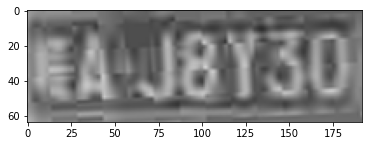

loading model...


NameError: name 'CRNN' is not defined

Error in callback <function _WandbInit._pause_backend at 0x7f9272db81e0> (for post_run_cell):


Exception: The wandb backend process has shutdown

In [12]:
# quick test
torch.cuda.set_device(0)
torch.cuda.empty_cache()

TRAINDIR = ['CCPD2019/train']
TESTDIR = ['CCPD2019/test']
VALDIR = ['CCPD2019/val']

LR = 0.001
PLATESIZE = (192,64) #(100,32)#(256,96)
BATCHSIZE = 16
EPOCH = 300

img_name = "CCPD2019/val/00348898467433-91_88-293&438_400&480-400&483_296&478_"+"298&442_402&447-0_0_8_32_22_27_24-115-7.jpg"
img = cv2.imread(img_name,cv2.IMREAD_GRAYSCALE)
lbl = img_name.split('/')[-1].rsplit('.', 1)[0].split('-')[-3]
iname = img_name.rsplit('/', 1)[-1].rsplit('.', 1)[0].split('-')
# corners = np.array(eval("[(" + iname[3].replace("&", ",").replace("_", "),(") + ")]"), np.float32) # [0] BR, [1] BL, [2] TL, [3] TR 
# print(corners) 
corners = np.array([[int(eel) for eel in el.split('&')] for el in iname[3].split('_')], np.float32)
print(corners)


resizedImage = persp_crop(img, corners, PLATESIZE[1],PLATESIZE[0])
[leftUp, rightDown] = [[int(eel) for eel in el.split('&')] for el in iname[2].split('_')]
# croppedImage = img[leftUp[1]:rightDown[1],leftUp[0]:rightDown[0]]
# resizedImage = cv2.resize(croppedImage, PLATESIZE)
# resizedImage = np.transpose(resizedImage, (2,0,1))
resizedImage = resizedImage.astype('float32')
resizedImage /= 255.0
XI = torch.tensor([[resizedImage]])
x = Variable(XI.cuda())
YI = torch.IntTensor([label_trans(el.split('_')[:7]) for el in [lbl]]).cuda()

plt.imshow(np.transpose([resizedImage,resizedImage,resizedImage],(1,2,0)))
plt.show()
# resizedImage = cv2.resize(resizedImage, (48,16))
# resizedImage = cv2.resize(resizedImage, PLATESIZE)
# plt.imshow(np.transpose([resizedImage,resizedImage,resizedImage],(1,2,0)))
# plt.show()
# input()
#     print(img)
print("loading model...")
# model = DigitRecog(PLATESIZE)
model = CRNN(imgH=32, nc=1, nclass=NUM_CHAR, nh=256, n_rnn=2, leakyRelu=False)
# model.load_state_dict(torch.load("weight/DigitRecog.pth14"))
model.load_state_dict(torch.load("weight/crnn.pth"))

model.cuda()
# model.eval()
model.train()

criterion = nn.CTCLoss(blank=NUM_CHAR-1,reduction='mean')

print("evaluating...")
print(debug.INFO+"input shape {}".format(x.shape))
y_pred = model(x)
print(debug.INFO+"output size:",y_pred.shape)
# input()
# print("y_pred",y_pred)

n_correct=0
_, preds = y_pred.max(2)
print("preds",preds.shape)
# preds = preds.squeeze(2)
# print("preds",preds.shape)
# print("preds",preds)
preds = preds.transpose(1, 0).contiguous()
print("preds",preds.shape)

print([chars[x] for x in YI[0].data])
print([chars[x] for x in preds[0]])
for i in range(YI.shape[0]):
    sim_preds, _ = decode(preds[i].data)
    print(sim_preds,YI[i].data)
    for pred, target in zip(sim_preds, YI[i].data):
        if pred == target:
            n_correct += 1
            
print(n_correct)
# print("preds",preds)
y_pred = F.log_softmax(y_pred,dim=2)
preds_size = Variable(torch.IntTensor([y_pred.size(0)] * 1))
tars_size = Variable(torch.IntTensor([7] * 1))
# print("loss input",y_pred,YI,preds_size,tars_size)
loss  = criterion(y_pred,YI,preds_size,tars_size)
print(loss)
# outputY = [el.data.cpu().numpy().tolist() for el in y_pred]
# try: 
#     print(outputY.shape)
# except:
#     pass 

# labelGT = np.array([[int(ee) for ee in el.split('_')[:7]] for el in [lbl]])
# labelPred = np.array([np.argmax(branch, axis=1) for branch in outputY])
# print(labelPred)
# scoreboard = (labelPred.T == labelGT)
# corr_eachinst = np.sum(scoreboard, axis=1)
# corr_eachchar = np.sum(scoreboard, axis=0)

# count, correct, error, precision, avgTime = eval(model=model, test_dirs=VALDIR)

In [89]:
# test on val dataset
torch.cuda.set_device(0)
torch.cuda.empty_cache()

# wandb.init(project='DigitRecog',settings=wandb.Settings(start_method="fork"))
# PLATESIZE = (256,96)
print("loading model...")
model = CRNN(imgH=32, nc=1, nclass=NUM_CHAR, nh=256, n_rnn=2, leakyRelu=False)
model.load_state_dict(torch.load("weight/crnn.pth"))
model.cuda()
model.eval()

print("evaluating...")
count, corrs_inst, precision, avgTime = eval(model=model, test_tar="CCPD2019/splits/val.txt")

loading model...
evaluating...
[INFO] -- Loading data under CCPD2019/splits/val.txt
init
[2, 3, 2, 2, 3, 2, 2, 2, 3, 2, 1, 3, 2, 2, 1, 2] 16
[2, 2, 3, 3, 3, 2, 3, 3, 2, 2, 2, 3, 3, 2, 2, 2] 16
[2, 3, 2, 2, 2, 4, 3, 3, 2, 2, 2, 2, 2, 2, 1, 2] 16
[1, 2, 3, 2, 1, 2, 2, 1, 2, 2, 2, 3, 2, 3, 2, 3] 16
[3, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 1, 2, 4, 2, 3] 16
[4, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 1, 1, 2, 2, 2] 16
[2, 3, 2, 2, 1, 3, 2, 0, 2, 2, 2, 2, 2, 3, 2, 2] 16
[3, 2, 2, 4, 2, 2, 3, 2, 3, 3, 2, 2, 3, 2, 2, 2] 16
[2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3] 16
[0, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 1, 2, 2, 2, 2] 16
[2, 2, 2, 3, 3, 2, 2, 2, 2, 1, 2, 2, 2, 1, 4, 2] 16
[2, 2, 2, 1, 2, 1, 2, 3, 4, 2, 2, 2, 2, 1, 2, 2] 16
[3, 2, 3, 2, 0, 2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2] 16
[2, 3, 2, 3, 3, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2] 16
[2, 1, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] 16
[2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 3, 2, 2, 3, 4, 2] 16
[3, 2, 2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 3, 3, 4, 2] 16
[3, 4, 4, 2, 2, 3, 1, 2, 2,

In [81]:
# test on val dataset
torch.cuda.set_device(0)
torch.cuda.empty_cache()

# wandb.init(project='DigitRecog',settings=wandb.Settings(start_method="fork"))
# PLATESIZE = (256,96)
print("loading model...")
model = DigitRecog(PLATESIZE)
model.load_state_dict(torch.load("weight/DigitRecog.pth14"))
model.cuda()
model.eval()

print("evaluating...")
count, corrs_inst, corrs_char, avgTime = eval(model=model, test_tar="CCPD2019/splits/val.txt")

loading model...


NameError: name 'DigitRecog' is not defined

In [ ]:
# test on val dataset
torch.cuda.set_device(0)
torch.cuda.empty_cache()

# wandb.init(project='DigitRecog',settings=wandb.Settings(start_method="fork"))
# PLATESIZE = (100,32)
print("loading model...")
model = CRNN(imgH=32, nc=1, nclass=NUM_CHAR, nh=256, n_rnn=2, leakyRelu=False)
model.load_state_dict(torch.load("weight/crnn.pth"))
model.cuda()
model.eval()

print("evaluating...")
count, corrs_inst, corrs_char, avgTime = eval(model=model, test_tar="CCPD2019/splits/val.txt")

In [ ]:

dst = labelFpsPathDataLoader("CCPD2019/splits/val.txt","CCPD2019", PLATESIZE)
bsz = 8
testloader = Data.DataLoader(dst, batch_size=bsz, shuffle=True, num_workers=8)
plt.imshow(list(testloader)[0])

In [11]:
print(np.mean(corrs_inst), corrs_char/count)

4.4481879275171 [0.98340934 0.98539942 0.03967159 0.07424297 0.68791752 0.73018921
 0.94735789]


In [16]:
for i in range(8):
    print("correct# %d"%i,(corrs_inst[corrs_inst==i]).sum())
print(corrs_char)

correct# 0 0.0
correct# 1 52.0
correct# 2 1192.0
correct# 3 28647.0
correct# 4 156392.0
correct# 5 229045.0
correct# 6 28500.0
correct# 7 973.0
[98337. 98536.  3967.  7424. 68789. 73016. 94732.]


In [53]:
im = np.random.randn(32)
im2 = np.random.randn(30)
len(list(zip(im,im2)))
# print(im.shape)
# im = np.expand_dims(im,2)
# print(im.shape)

30